In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
tr = pd.read_parquet('train.parquet')

In [4]:
index_split = tr.index.str.split('_')

In [5]:
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)
tr['row_id'] = tr.row_num + '_' + tr.row_type

In [6]:
X = tr.pivot(index='row_id', columns='timestamp', values='Values')

In [2]:
X = pd.read_parquet('X.pq')
X = X.pivot(index='row_id', columns='timestamp', values='Values')
X.columns = ['tr_' + str(col) for col in X.columns]

Первый шаг - усредним по периоду недели - 2016

In [3]:
def mean_model(rows, horizont_index, rows_size, periods = 4):
    perodic_points = horizont_index + rows_size - 2016 * (np.arange(periods) + 1)
    return np.mean(rows.iloc[:,perodic_points], axis = 1)

for i in range(100):
    X[f'pred_{i}'] = mean_model(X, i, 17756)

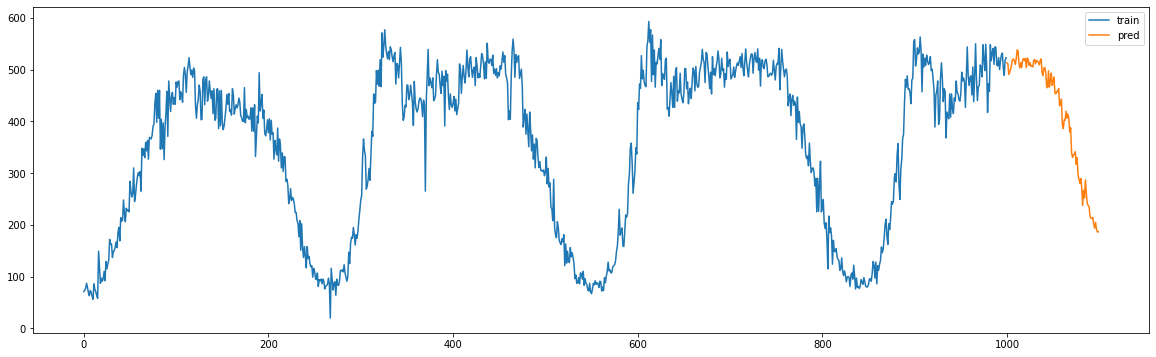

In [4]:
hue_col = ['train'] * 1000 + ['pred'] * 100

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=np.arange(1100), y=X.loc[['1_0']].iloc[0,-1100:].values, hue=hue_col, n_boot=0)
plt.gcf().set_size_inches(20, 6)

Оценим качество. Для этого сделаем кросс валидацию - будем предсказывать ряд на предыдущих периодах

In [280]:
def make_cv_folds(rows, h = 100):
    cv_folds = [] 
    for i in range(1, 5):
        cv_folds.append((rows.iloc[:, :-i * 2016], rows.iloc[:,-i * 2016: -i * 2016 + h]))
    return cv_folds
def get_metric(pred, true, train, for_each_row = False):
    T = train.shape[1]
    weight = 1 / (T - 1) * np.sum(np.abs(train[:,1:] - train[:,:-1]), axis = 1)
    if for_each_row:
            return np.mean(np.abs(pred - true) / np.clip(weight[:,np.newaxis],0.0001,np.inf), axis = 1)
    return np.mean(np.abs(pred - true) / np.clip(weight[:,np.newaxis],0.0001,np.inf))
    
folds = make_cv_folds(X.iloc[:,:17756])
metrics = []
for fold in folds:
    y_pred = np.zeros((fold[0].shape[0], 100))
    for i in range(100):
        y_pred[:,i] = mean_model(fold[0], i,fold[0].shape[1])
    metrics.append(get_metric(y_pred,fold[1].values,fold[0].values))
metrics = np.array(metrics)
metrics.mean()

1.7348618300006358

Посмотрим распределение по рядам:

87


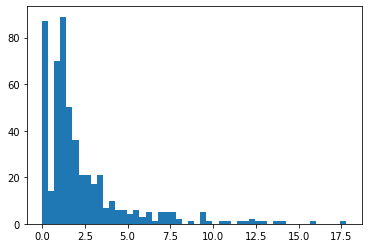

In [471]:
folds = make_cv_folds(X.iloc[:,:17755],h = 50)
metrics = []
for fold in folds:
    y_pred = np.zeros((fold[0].shape[0], 50))
    for i in range(50):
        y_pred[:,i] = mean_model(fold[0], i,fold[0].shape[1])
    metrics.append(get_metric(y_pred,fold[1].values,fold[0].values, for_each_row=True))
metrics = np.array(metrics)
print((metrics.mean(axis = 0) == 0).sum())
_,_,_ = plt.hist(metrics.mean(axis = 0), bins = 50)

Видно, что есть много нулей. Т.е существуют идеально периодичные ряды

Посмотрим, существуют ли ряды, которые отличаются на константу в каждом периоде. Для этого нужно учесть сезонность 

In [113]:
X.iloc[:,:17756].nunique(axis = 1)[X.iloc[:,:17756].nunique(axis = 1) < 400]

row_id
100_0    280
100_2    381
101_2    277
102_0    161
103_0    163
        ... 
97_2     258
98_0     277
98_2     173
99_0     289
99_2     242
Length: 215, dtype: int64

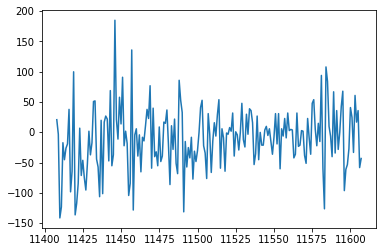

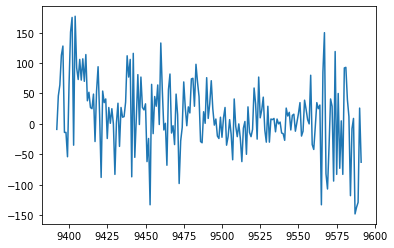

In [103]:
plt.plot(Y.iloc[504][-300:-100])
plt.figure()
plt.plot(Y.iloc[504][-300 - 2016:-100 - 2016])

(686.0823529411765, 1152.9549019607844)

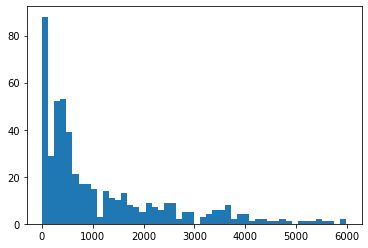

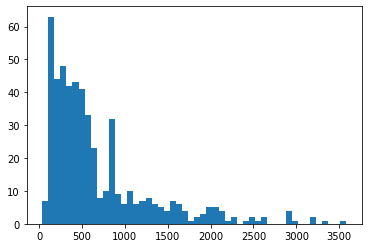

In [112]:
Y = X.iloc[:,:17756]
def make_D(rows, T):
    return pd.DataFrame(rows.iloc[:,T:].values - rows.iloc[:,:-T].values)
Y =   make_D(Y,  2016)
_,_,_ = plt.hist(Y.nunique(axis = 1), bins = 50)
plt.figure()
_,_,_ = plt.hist(X.iloc[:,:17756].nunique(axis = 1), bins = 50)
X.iloc[:,:17756].nunique(axis = 1).mean(), Y.nunique(axis = 1).mean()

Как видно, диференцирование ряда не приводит к ступенчатым функциям.Но как можно заметить есть ряды, количество значений в которых не очень много. Для оценки, для каждого икса у нас будет около 200 испытаний в баесвоской модели. Это слишком мало. кроме того, наши вероятности очень зависимы. Не ожидается что этот способ сработает

In [351]:
def full_roll(a, inverse):    
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    if inverse:
        return rolling_window(np.concatenate((a, a)), len(a))[:-1]
    else:
        return np.fliplr(rolling_window(np.flipud(np.concatenate((a, a))), len(a))[:-1])

def add_probs(row, value_index_dict, probs_x, probs_y):
    probs_x[value_index_dict[row[-1]]] += row[:-1]
    probs_y[value_index_dict[row[-1]]] += 1

def baes_model(rows, i, indices):
    predicted = np.zeros(len(rows))
    for count, (index, row) in enumerate(rows.iterrows()):
        features = row.iloc[-indices].values
        num_features = len(indices)
        uniq_values = row.unique() 
        value_index_dict = dict((value,j) for (j,value) in enumerate(uniq_values))
        mask = np.zeros(len(row))
        new_indices = list(-indices[::-1] + indices[-1])
        mask[new_indices + [indices[-1] + i]] = 1
        mask = full_roll(mask,0)[:len(row) - indices[-1] - i]
        len_matrix = len(row) - indices[-1] - i
        train_matrix = np.tile(row.values,(len_matrix,1))[mask == 1].reshape((-1, len(features) + 1))
        train_matrix[:,:-1] = train_matrix[:,:-1] == np.tile(features,(len_matrix,1))
        probs_x = np.ones((len(uniq_values), num_features))
        probs_y = np.ones((len(uniq_values), num_features))
        _ = np.apply_along_axis(lambda row: add_probs(row, value_index_dict, probs_x, probs_y), 1, train_matrix)
        probs = np.prod(probs_x / np.clip(probs_y, 0.001, np.inf), axis = 1)
        predicted[count] = uniq_values[np.argmax(probs)]
    return predicted

In [478]:
Test_rows = X.iloc[:,:17756][metrics.mean(axis = 0) > 5]


In [479]:
Test_rows.shape

(55, 17756)

8.212036484939436


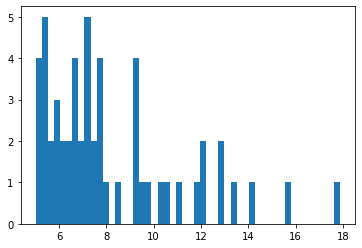

In [483]:
folds = make_cv_folds(Test_rows, h = 50)
metrics = []
for fold in folds:
    y_pred = np.zeros((fold[0].shape[0], 50))
    for i in range(50):
        y_pred[:,i] = mean_model(fold[0], i,fold[0].shape[1])
    metrics.append(get_metric(y_pred,fold[1].values,fold[0].values, for_each_row=True))
metrics = np.array(metrics)
print(metrics.mean(axis = 0).mean())
_,_,_ = plt.hist(metrics.mean(axis = 0), bins = 50)

In [466]:
metrics.mean(axis = 0).mean()

9.881898904416776

Попробуем сделать следующие вещи:
    возьмем худшие ряды сделаем для них предсказание с помощью авторегрессии с выкидыванием выходных дней и каких-нибудь еще, ожидается что это улучшит качество.
    далее попробуем посмотетреть на худшие ряды в этом случае и попробуем исправить их вручную

In [388]:
from prophet import Prophet

In [410]:
import datetime
delta_5_min = datetime.timedelta(minutes=5)
start_date = datetime.datetime(2023,5,13)
dates = np.array([start_date + i * delta_5_min for i in range(17756)]).astype(datetime.datetime)
weekends = np.array([(date.weekday() == 5) or (date.weekday() == 6) for date in dates])

In [417]:
Test_rows.shape, weekends.shape

((3, 17756), (17756,))

In [486]:
def model_prophnet(rows,h = 100):
    #drop mon and weekend
    delta_5_min = datetime.timedelta(minutes=5)
    start_date = datetime.datetime(2023,5,13)
    dates = np.array([start_date + i * delta_5_min for i in range(rows.shape[1])]).astype(datetime.datetime)
    weekends = np.array([(date.weekday() == 5) or (date.weekday() == 6) or (date.weekday() == 0) for date in dates])
    rows = rows.iloc[:,weekends == 0]
    predictions = np.zeros((len(rows), h))
    for i, (index, row) in enumerate(rows.iterrows()):
        training_data = pd.DataFrame(np.c_[row, dates[weekends == 0]], columns = ['y', 'ds'])
        model = Prophet()
        model = model.fit(training_data)
        feature_df = pd.DataFrame([dates[-1] + (i+1)*delta_5_min for i in range(h)], columns = ['ds'])
        feature_df= model.predict(feature_df)
        predictions[i] = feature_df['yhat'].values
    return predictions
        

In [501]:
import prophet
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

6.842867532544714


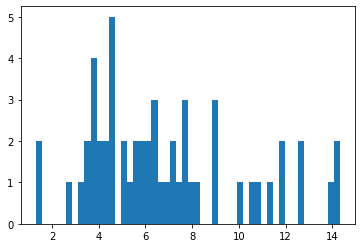

In [711]:
folds = make_cv_folds(Test_rows, h = 50)
metrics = []
predictions = np.zeros((len(folds), folds[0][0].shape[0], 50))
for i,fold in enumerate(folds):
    y_pred = np.zeros((fold[0].shape[0], 50))
    y_pred = model_prophnet(fold[0],h=50)
    predictions[i] = y_pred
    metrics.append(get_metric(y_pred,fold[1].values,fold[0].values, for_each_row=True))
metrics = np.array(metrics)
print(metrics.mean(axis = 0).mean())
_,_,_ = plt.hist(metrics.mean(axis = 0), bins = 50)

6.842867532544714


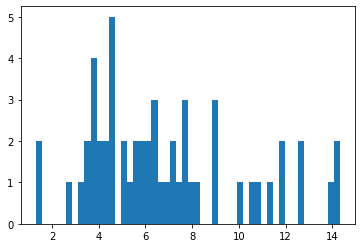

In [700]:
#Посмотрим на худшие предсказания
print(metrics.mean(axis = 0).mean())
_,_,_ = plt.hist(metrics.mean(axis = 0), bins = 50)

In [699]:
(metrics.mean(axis = 0) > 6).sum(), metrics.mean(axis = 0)[metrics.mean(axis = 0) > 6].mean()

(29, 9.21866331281483)

Видно, что наше предсказание ингда слишком сглаженное, а иногда отстоит на константу. Для решения данной проблемы можно воспользоваться растягивающей функцией на рядах поддверженных этой проблеме. Для этого придется найти такие ряды вручную

In [701]:
def scaling(prediction, strength):
    indices = np.arange(len(prediction))
    indices[-25:] = indices[:25][::-1]
    return prediction - strength * indices * prediction

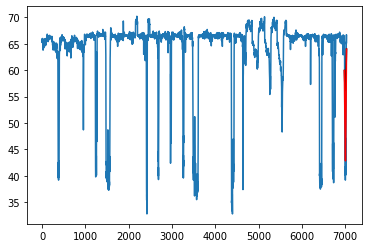

In [749]:
prediction = predictions[0][metrics.mean(axis = 0) > 6][5]
row = Test_rows[metrics.mean(axis = 0) > 6].iloc[5].values[-9000:-2016 + 50]
plt.plot(row)
plt.plot(np.arange(len(prediction)) + len(row) - 50,prediction,c='black')
plt.plot(np.arange(len(prediction)) + len(row) - 50,scaling(prediction,0.01),c='red')

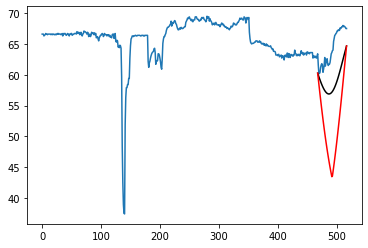

In [746]:
prediction = predictions[1][metrics.mean(axis = 0) > 6][5]
row = Test_rows[metrics.mean(axis = 0) > 6].iloc[5].values[-2000 -2500:-2*2016 + 50]
plt.plot(row)
plt.plot(np.arange(len(prediction)) + len(row) - 50,prediction,c='black')
plt.plot(np.arange(len(prediction)) + len(row) - 50,scaling(prediction,0.01),c='red')

In [830]:
Rows_to_scale = [
                 (0,-0.005),
                 (1,0.006),
                 #(5,0.01),
                 #(6,0.005),
                 (7, -0.01),
                 #(11,0.014),
                 (12,0.02),
                 #(14,0.025),
                 (15,-0.02),
                 (16,0.01),
                 #(21,0.03),
                 (26, 0.02),
                 (28,0.01)
                ]

In [831]:
rows = Test_rows[metrics.mean(axis = 0) > 6].iloc[[row[0] for row in Rows_to_scale]].index
dict_row_scaling_strength = dict((row,Rows_to_scale[i][1]) for (i,row) in enumerate(rows))

Посмотрим на качество после скейлинга

6.665572724031214


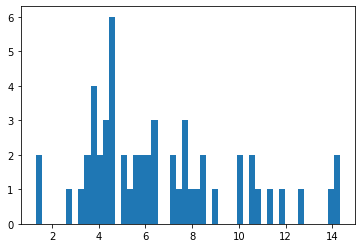

In [832]:
folds = make_cv_folds(Test_rows, h = 50)
metrics_new = []
predictions_new = np.zeros((len(folds), folds[0][0].shape[0], 50))
for i,fold in enumerate(folds):
    for j,prediction in enumerate(predictions[i]):
        if dict_row_scaling_strength.get(fold[0].iloc[j].name,None) is not None:
            predictions_new[i][j] = scaling(prediction,dict_row_scaling_strength[fold[0].iloc[j].name])
        else:
            predictions_new[i][j] = prediction
    metrics_new.append(get_metric(predictions_new[i], fold[1].values,fold[0].values, for_each_row=True))
metrics_new = np.array(metrics_new)
print(metrics_new.mean(axis = 0).mean())
_,_,_ = plt.hist(metrics_new.mean(axis = 0), bins = 50)

Смогли немного улучшить качество таким способом

Для итого предсказания нужно похожим образом вручную посмотреть ряды, чтобы сдвинуть их на нужную константу